# Variational AutoEncoder Continued

## Biweekly Report 3

## Jake Watts


In this section of the report, I experiment with the architecture of the VAE to see how changes affect the training loss and image generation quality. I first train a model with increased width on the convolutional layers. I then train a model without increased convolutional width but with a larger latent vector.

My hypothesis is that increasing the dimensions of the latent vector will result in a bigger decrease in the loss function because the latent vector is essentially an information bottleneck so increasing it will allow more information to pass through the network.

With regards to increasing convolutional width, I am not sure if it will have an effect on the loss function as the informational bottleneck will remain the same, so it will be interesting to see if the loss increases or decreases compared to the original model. 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model

In [ ]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255

## Increasing Architecture Width

Sampling function

In [ ]:

class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


The architecture for the `encoder` is exactly the same as the original model except that the convolutional layers have 64 and 128 filters respectively rather than 32 and 64.

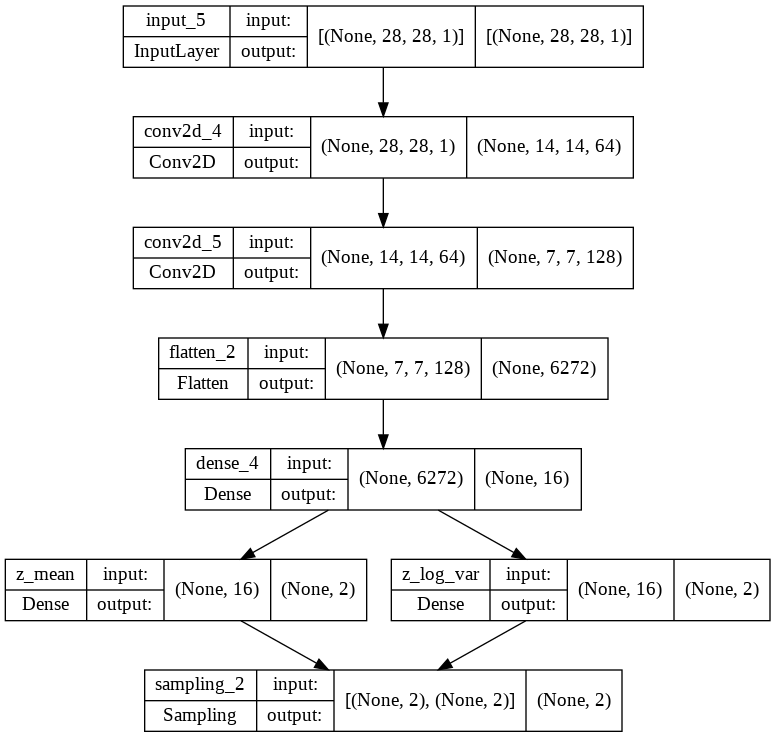

In [ ]:
latent_dim = 2

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(128, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

plot_model(encoder, to_file='model.png', show_shapes=True, show_layer_names=True)

The `decoder` convolutional layers are also changed to 128 and 64.

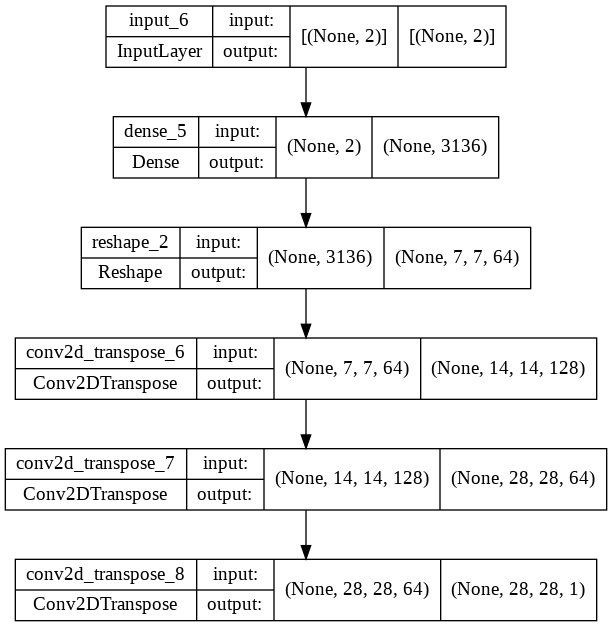

In [ ]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(128, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")

plot_model(decoder, to_file='model.png', show_shapes=True, show_layer_names=True)

Loss function

In [ ]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }


I increase the epochs here from 30 to 50 since there are now more parameters to train.

In [ ]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
h_callback2 = vae.fit(mnist_digits, epochs=50, batch_size=128)

Epoch 1/50
547/547 [==============================] - 7s 12ms/step - loss: 242.3395 - reconstruction_loss: 201.0103 - kl_loss: 3.1254
Epoch 2/50
547/547 [==============================] - 6s 12ms/step - loss: 171.2832 - reconstruction_loss: 162.9674 - kl_loss: 4.1934
Epoch 3/50
547/547 [==============================] - 6s 12ms/step - loss: 160.0832 - reconstruction_loss: 154.7669 - kl_loss: 4.1020
Epoch 4/50
547/547 [==============================] - 6s 12ms/step - loss: 155.9162 - reconstruction_loss: 151.5186 - kl_loss: 4.1282
Epoch 5/50
547/547 [==============================] - 6s 12ms/step - loss: 154.1279 - reconstruction_loss: 149.4642 - kl_loss: 4.1340
Epoch 6/50
547/547 [==============================] - 7s 12ms/step - loss: 151.9549 - reconstruction_loss: 147.8972 - kl_loss: 4.1515
Epoch 7/50
547/547 [==============================] - 7s 13ms/step - loss: 150.9777 - reconstruction_loss: 146.5526 - kl_loss: 4.1449
Epoch 8/50
547/547 [==============================] - 6s 12ms/

Looking at the graph we can see that the KL loss slightly increases again while the reconstruction loss decreases the most in the first five epochs. At the end of the training, the total loss is 138.52 while the original VAE's loss was 145.46. However, the KL loss is higher for this model than the original (4.1 vs 3.7).

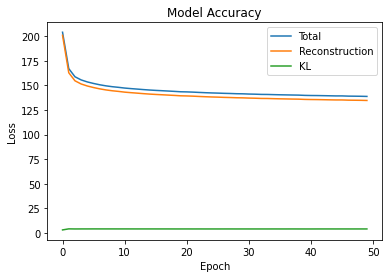

In [ ]:
plt.figure()
plt.plot(h_callback2.history['loss'])
plt.plot(h_callback2.history['reconstruction_loss'])
plt.plot(h_callback2.history['kl_loss'])
plt.title('Model Accuracy')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Total', 'Reconstruction', 'KL'], loc='upper right')
plt.show()

The latent space looks very similar to the original model. Some of the numbers are even looking to be in the same position such as how the top row has 8's on the right and 0's on the left.

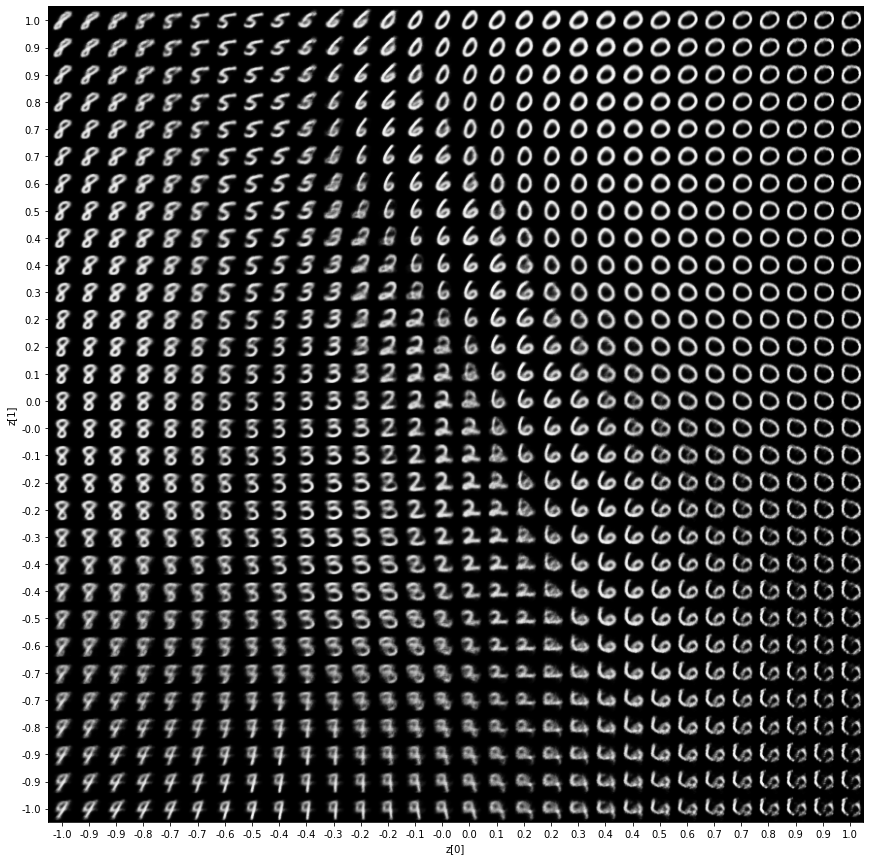

In [ ]:
def plot_latent_space(vae, n=30, figsize=15):
    # display a n*n 2D manifold of digits
    digit_size = 28
    scale = 1.0
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = vae.decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent_space(vae)

The cluster of labels is also similar to the original model in that the 1's and 0's groups are very clearly separated. In general, it appears that most have regions that overlap less and are easier to identify such as the number 7. The grouping that looks the most strange to me is 4 which appears to be shaped like a circle with most of the pints at the edge rather than the middle.

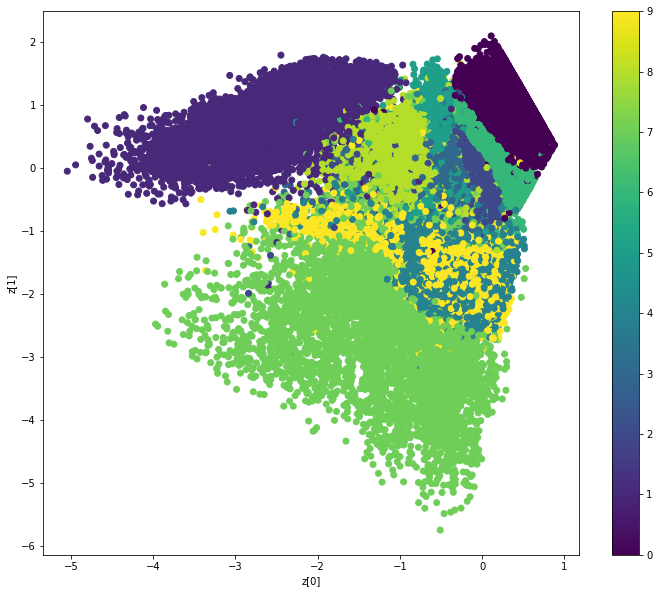

In [ ]:
def plot_label_clusters(vae, data, labels):
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = vae.encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()

(x_train, y_train), _ = keras.datasets.mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255
plot_label_clusters(vae, x_train, y_train)

`display imgs` allows us to view mulitple images in a line.

In [ ]:
def display_imgs(x, y=None):
  if not isinstance(x, (np.ndarray, np.generic)):
    x = np.array(x)
  plt.ioff()
  n = x.shape[0]
  fig, axs = plt.subplots(1, n, figsize=(n, 1))
  if y is not None:
    fig.suptitle(np.argmax(y, axis=1))
  for i in range(n):
    axs.flat[i].imshow(x[i].squeeze(), interpolation='none', cmap='gray')
    axs.flat[i].axis('off')
  plt.show()
  plt.close()
  plt.ion()

Here are the first ten images from the training.

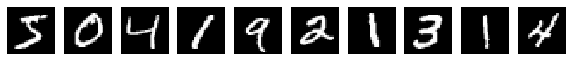

In [ ]:
imgs = x_train[0:10]
display_imgs(imgs)

Similar to the original model, the resulting images from the model look a little blurry for numbers other than 0 or 1.

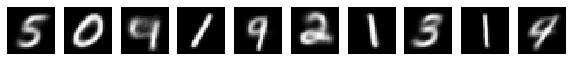

In [ ]:
mu, sigma, ran = vae.encoder.predict(imgs)
gi = vae.decoder.predict(ran)
display_imgs(gi)

## Increasing Latent Vector Dimensions

Here I change the latent vector dimension from 3 to 4.

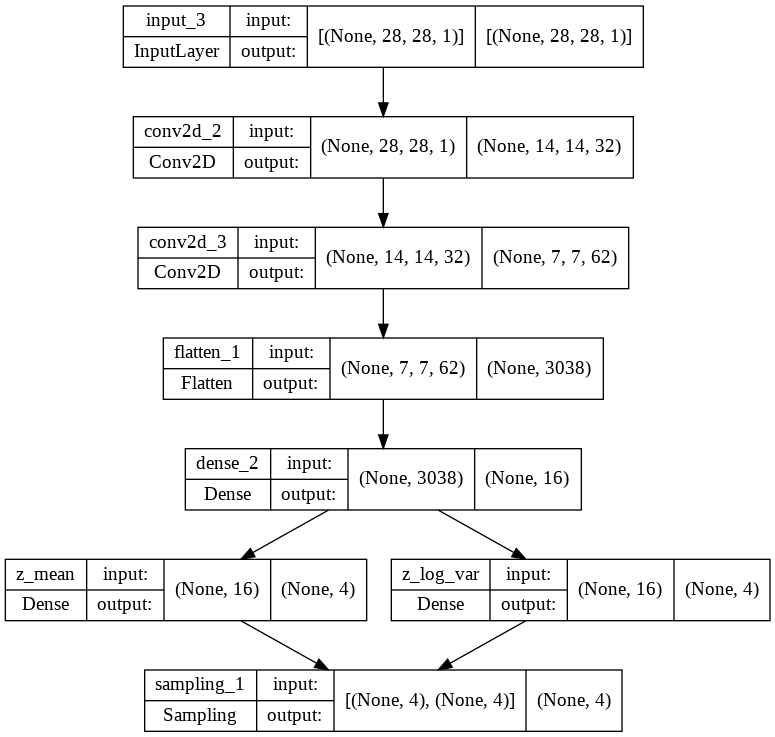

In [ ]:
latent_dim = 4

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(62, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

plot_model(encoder, to_file='model.png', show_shapes=True, show_layer_names=True)

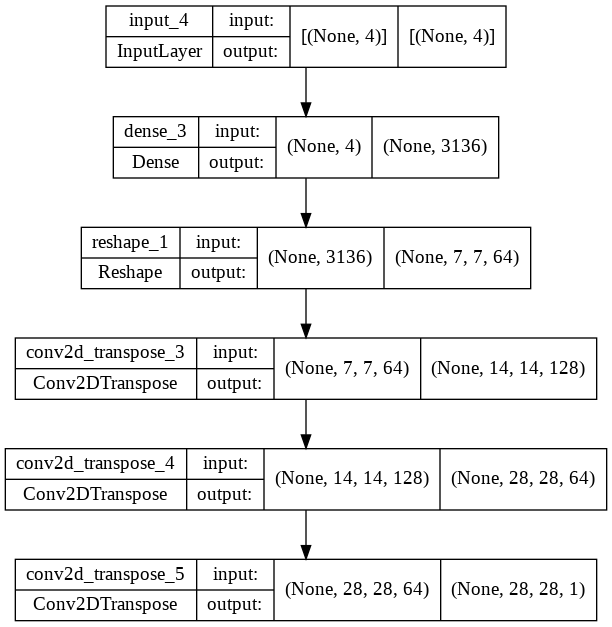

In [ ]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(128, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")

plot_model(decoder, to_file='model.png', show_shapes=True, show_layer_names=True)

In [ ]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

Training the model for 50 epochs.

In [ ]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
h_callback3 = vae.fit(mnist_digits, epochs=50, batch_size=128)

Epoch 1/50
547/547 [==============================] - 8s 11ms/step - loss: 243.9205 - reconstruction_loss: 192.4063 - kl_loss: 2.4260
Epoch 2/50
547/547 [==============================] - 6s 11ms/step - loss: 138.8215 - reconstruction_loss: 131.3148 - kl_loss: 3.9920
Epoch 3/50
547/547 [==============================] - 6s 11ms/step - loss: 130.2869 - reconstruction_loss: 125.3730 - kl_loss: 3.9073
Epoch 4/50
547/547 [==============================] - 6s 11ms/step - loss: 127.5226 - reconstruction_loss: 122.9891 - kl_loss: 3.8457
Epoch 5/50
547/547 [==============================] - 7s 12ms/step - loss: 125.5140 - reconstruction_loss: 121.4651 - kl_loss: 3.7767
Epoch 6/50
547/547 [==============================] - 7s 13ms/step - loss: 124.4912 - reconstruction_loss: 120.3243 - kl_loss: 3.7240
Epoch 7/50
547/547 [==============================] - 7s 12ms/step - loss: 123.2427 - reconstruction_loss: 119.3705 - kl_loss: 3.6913
Epoch 8/50
547/547 [==============================] - 7s 12ms/

The loss here is the smallest out of any model so far in both the reconstruction loss and the KL loss. It again appears that the KL loss increases slightly, however not as much as before. I suspect with more information being able to flow through the network there is less need for as large of a trade-off to decrease the total loss.

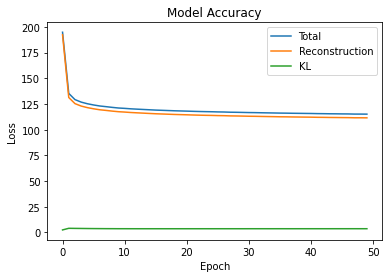

In [ ]:
plt.figure()
plt.plot(h_callback3.history['loss'])
plt.plot(h_callback3.history['reconstruction_loss'])
plt.plot(h_callback3.history['kl_loss'])
plt.title('Model Accuracy')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Total', 'Reconstruction', 'KL'], loc='upper right')
plt.show()

Since the latent dimension is greater than two it is now more difficult to visualize the latent space as it would now be 4 dimensions. However, we can still compare the model input with the model output.

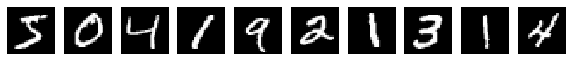

In [ ]:
imgs = x_train[0:10]
display_imgs(imgs)

The output from the model with a latent dimension of 4 appears to be less blurry than the previous models. For example, the 4 at the end looked pretty blurry in the other models but looks a lot clearer here.

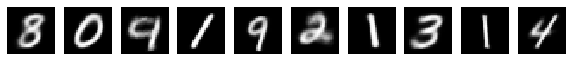

In [ ]:
mu, sigma, ran = vae.encoder.predict(imgs)
gi = vae.decoder.predict(ran)
display_imgs(gi)

## Summary

Looking at how architecture changes affected model output helped me get a better understanding of how VAEs work. It appears that increasing latent vector size is more effective than increasing convolution width for model performance. This makes sense as VAE sense since the model with the larger width still has to pass the information through the same size bottleneck. I also suspect that if I were to increase the latent dimension and the convolutional width at the same time we would see an even larger decrease in the loss function.